True H: 0.6
Estimated H (MAP): 0.59
Difference from true H: 0.010000000000000009


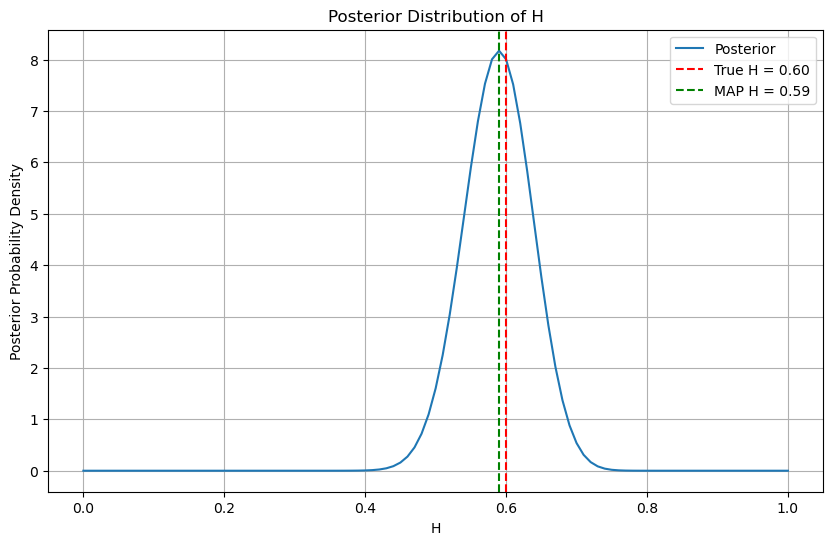

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import special

## Generate some coin flipping data
H_true = 0.6  
n = 100       ## flip the coin 100 times
  
data = np.random.rand(n)
h = int(np.sum(np.ceil(data[np.where(data <= H_true)])))  ## counts number of heads

## apply Bayes' theorem to estimate H
prior = 1     
dH = 0.01
H_vals = np.arange(0, 1 + dH, dH)

posterior = []

for H in H_vals:
    # Likelihood from the binomial distribution
    likelihood = special.comb(n, h) * (H**h) * ((1 - H)**(n - h))
    # Posterior is proportional to likelihood * prior
    post_val = prior * likelihood
    posterior.append(post_val)

posterior = np.array(posterior)

# Normalize the posterior
posterior = posterior / (np.sum(posterior) * dH)

# Find the MAP estimate
map_index = np.argmax(posterior)
map_H = H_vals[map_index]

print(f"True H: {H_true}")
print(f"Estimated H (MAP): {map_H}")
print(f"Difference from true H: {abs(map_H - H_true)}")

# Plot the posterior
plt.figure(figsize=(10, 6))
plt.plot(H_vals, posterior, label='Posterior')
plt.axvline(H_true, color='r', linestyle='--', label='True H = {:.2f}'.format(H_true))
plt.axvline(map_H, color='g', linestyle='--', label='MAP H = {:.2f}'.format(map_H))
plt.xlabel('H')
plt.ylabel('Posterior Probability Density')
plt.title('Posterior Distribution of H')
plt.legend()
plt.grid(True)
plt.show()


100%|██████████| 1000/1000 [00:05<00:00, 184.16it/s]


True H: 0.5
Mean of H posterior: 0.5061
Median of H posterior: 0.5061
Std of H posterior: 0.0223


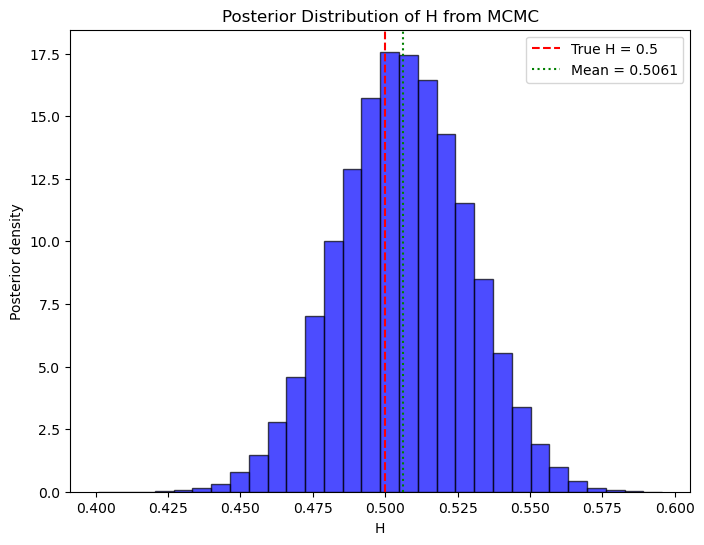

In [ ]:
import numpy as np
import emcee
from numpy.random import randn, rand
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import corner
from timeit import default_timer as timer
from scipy.special import comb



# returns the log of the chosen prior
def log_prior(H):
    if 0 <= H <= 1:
        return 0.0  # log(1) = 0
    else:
        return -np.inf

# returns the log-likelihood
def log_likelihood(H, h, n):
    # Ensure H is within valid range
    if (H <= 0) or (H >= 1):
        return -np.inf
    # Likelihood = C(n,h)*H^h*(1-H)^(n-h)
    # On a log scale, ignoring constant C(n,h):
    # log_likelihood = h*log(H) + (n-h)*log(1-H)
    return h * np.log(H) + (n - h) * np.log(1 - H)

# returns the log posterior = log_prior(H) + log_likelihood(H,h,n)
def log_posterior(H, h, n):
    lp = log_prior(H)
    if not np.isfinite(lp):
        return -np.inf
    ll = log_likelihood(H, h, n)
    return lp + ll



ndim = 1         
n_walkers = 200   

# generating the "observed data"
n = 500
H_true = 0.5
data = np.random.rand(n)
# count how many heads:
h = int(np.sum(np.ceil(data[np.where(data >= H_true)])))



p0 = np.random.rand(n_walkers, ndim)

# Instantiate the sampler:
sampler = emcee.EnsembleSampler(n_walkers, ndim, log_posterior, args=[h, n])

# Run a few "burn in" steps to let the chains stabilize
burn_in_steps = 1000
state = sampler.run_mcmc(p0, burn_in_steps)
sampler.reset()

# Now run the main MCMC sampler for production
n_steps = 1000
sampler.run_mcmc(state, n_steps, progress=True)


samples = sampler.get_chain(flat=True)
H_samples = samples[:,0]

# Compute the mean, median, and standard deviation of H from the samples
H_mean = np.mean(H_samples)
H_median = np.median(H_samples)
H_std = np.std(H_samples)

print(f"True H: {H_true}")
print(f"Mean of H posterior: {H_mean:.4f}")
print(f"Median of H posterior: {H_median:.4f}")
print(f"Std of H posterior: {H_std:.4f}")



fig, ax = plt.subplots(figsize=(8,6))
ax.hist(H_samples, bins=30, density=True, alpha=0.7, color='blue', edgecolor='black')
ax.axvline(H_true, color='r', linestyle='--', label=f"True H = {H_true}")
ax.axvline(H_mean, color='g', linestyle=':', label=f"Mean = {H_mean:.4f}")
ax.set_xlabel('H')
ax.set_ylabel('Posterior density')
ax.set_title('Posterior Distribution of H from MCMC')
ax.legend()
plt.show()




# If you change n_walkers:
# - Fewer walkers (e.g. <10)  leads to poorer exploration of the parameter space,
#   and the chain may not mix well, resulting in a biased posterior estimate or
#   longer required burn-in time.
# - More walkers can improve the coverage and robustness of the chain, but it takes
#   more computation time.

# If you change n_steps:
# - Fewer steps resulted in better estimates.(surprisingly)
# 




100%|██████████| 2000/2000 [00:03<00:00, 518.69it/s]


True H: 0.5
Mean of H posterior: 0.8066
Median of H posterior: 0.8067
Std of H posterior: 0.0077


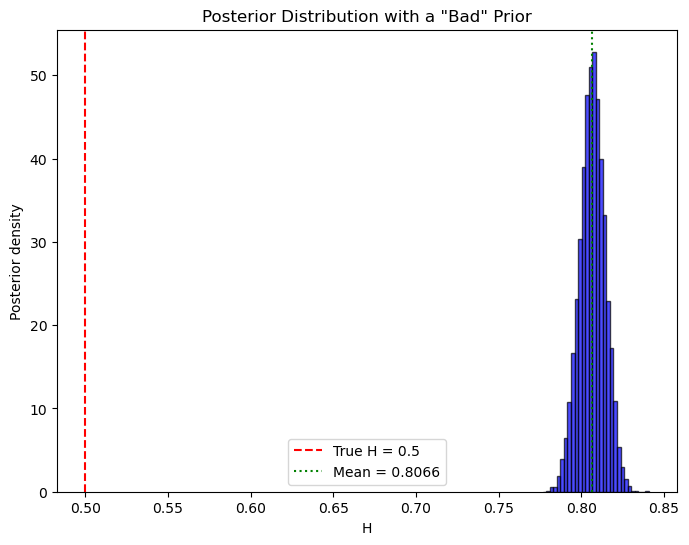

In [ ]:
import numpy as np
import emcee
import matplotlib.pyplot as plt
import corner

# "Bad" prior: strongly peaked around H=0.9
def log_prior(H):
    # Let's define a Gaussian-like prior centered at 0.9 with a small std dev:
    # prior(H) = exp(-(H-0.9)^2 / (2*0.01^2))
    # On a log scale:
    if 0 <= H <= 1:
        mean = 0.9
        sigma = 0.01
        return -((H - mean)**2) / (2*sigma**2) - np.log(sigma * np.sqrt(2*np.pi))
    else:
        return -np.inf

def log_likelihood(H, h, n):
    if H <= 0 or H >= 1:
        return -np.inf
    return h * np.log(H) + (n - h) * np.log(1 - H)

def log_posterior(H, h, n):
    lp = log_prior(H)
    if not np.isfinite(lp):
        return -np.inf
    ll = log_likelihood(H, h, n)
    return lp + ll

# Generate data
np.random.seed(42)
n = 500
H_true = 0.5
data = np.random.rand(n)
h = int(np.sum(np.ceil(data[np.where(data>=H_true)])))

ndim = 1
n_walkers = 32

# Starting points for walkers
p0 = np.random.rand(n_walkers, ndim)

sampler = emcee.EnsembleSampler(n_walkers, ndim, log_posterior, args=[h, n])
# Burn-in steps
burn_in_steps = 1000
state = sampler.run_mcmc(p0, burn_in_steps)
sampler.reset()

# Production steps
n_steps = 2000
sampler.run_mcmc(state, n_steps, progress=True)

samples = sampler.get_chain(flat=True)
H_samples = samples[:,0]

H_mean = np.mean(H_samples)
H_median = np.median(H_samples)
H_std = np.std(H_samples)

print(f"True H: {H_true}")
print(f"Mean of H posterior: {H_mean:.4f}")
print(f"Median of H posterior: {H_median:.4f}")
print(f"Std of H posterior: {H_std:.4f}")

# Plot posterior
plt.figure(figsize=(8,6))
plt.hist(H_samples, bins=30, density=True, alpha=0.7, color='blue', edgecolor='black')
plt.axvline(H_true, color='r', linestyle='--', label=f"True H = {H_true}")
plt.axvline(H_mean, color='g', linestyle=':', label=f"Mean = {H_mean:.4f}")
plt.xlabel('H')
plt.ylabel('Posterior density')
plt.title('Posterior Distribution with a "Bad" Prior')
plt.legend()
plt.show()
# If you use a "bad" prior:
# - A prior heavily favoring values of H near 0 or 1  skews the
#   posterior away from the data-informed center (near 0.5 if the data is consistent
#   with a fair coin).
# - This would result in a posterior that does not match the data well, showing
#   how sensitive Bayesian inference can be to prior assumptions.


100%|██████████| 5000/5000 [00:08<00:00, 594.06it/s]


True values: A=7.00, f=0.50, tau=5.00
Estimated A: 6.745 ± 0.220
Estimated f: 0.499 ± 0.001
Estimated tau: 5.201 ± 0.254


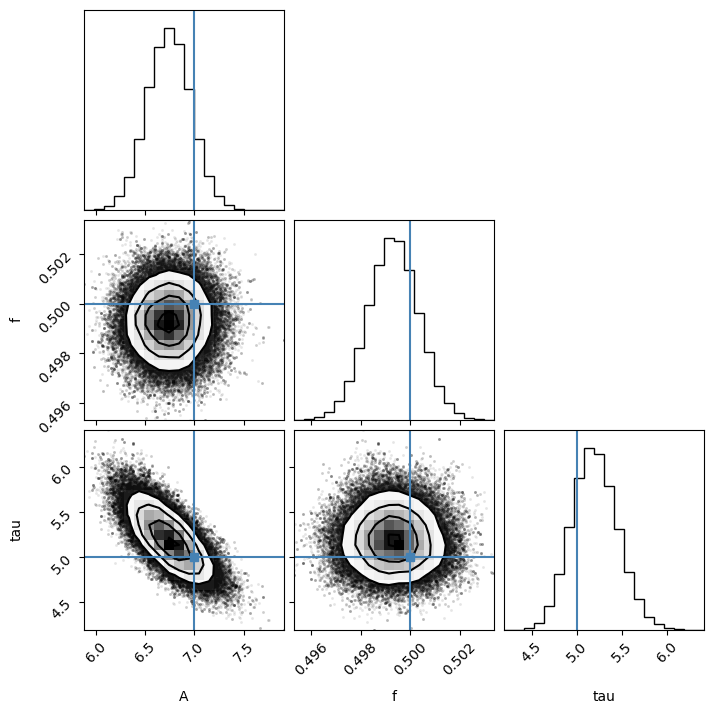

C:\Users\malek\AppData\Local\Temp\ipykernel_15248\688088035.py:101: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
c:\Users\malek\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


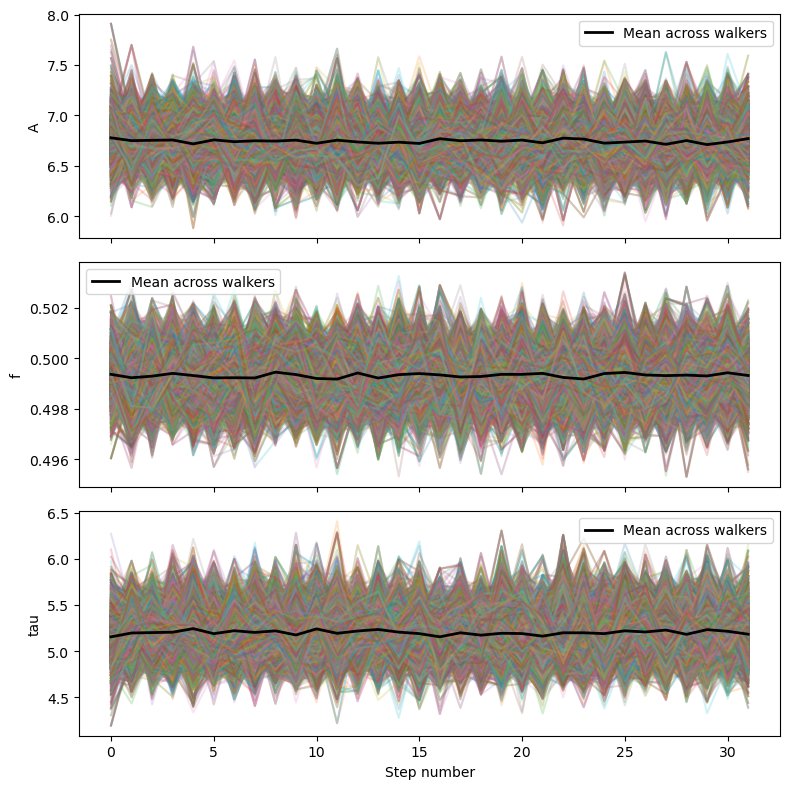

In [22]:
import numpy as np
import emcee
import matplotlib.pyplot as plt
import corner



def signalFunction(theta, tt):
    A, f, tau = theta
    return A * np.exp(-tt / tau) * np.sin(2 * np.pi * f * tt)

# Generate synthetic data
np.random.seed(42)
tt = np.linspace(0, 15, 500)
A_true = 7.0
f_true = 0.5
tau_true = 5.0
signal = signalFunction([A_true, f_true, tau_true], tt)
noise = np.random.randn(len(tt))
data = signal + noise



def log_prior(theta):
    A, f, tau = theta
    # Reasonable bounds:
    if 0 < A < 20 and 0 < f < 1 and 0.1 < tau < 10:
        return 0.0
    else:
        return -np.inf

def log_likelihood(theta, tt, data):
    model = signalFunction(theta, tt)
    residuals = data - model
    # Gaussian likelihood with unit variance
    return -0.5 * np.sum(residuals**2)

def log_posterior(theta, tt, data):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    ll = log_likelihood(theta, tt, data)
    return lp + ll



ndim = 3   # parameters: A, f, tau
n_walkers = 32

# Start walkers around the true values, but with some spread
initial_pos = [
    [A_true + 0.5*np.random.randn(),
     f_true + 0.05*np.random.randn(),
     tau_true + 0.5*np.random.randn()]
    for _ in range(n_walkers)
]

sampler = emcee.EnsembleSampler(n_walkers, ndim, log_posterior, args=(tt, data))

# Burn-in phase (discard these steps)
burn_in_steps = 1000
state = sampler.run_mcmc(initial_pos, burn_in_steps, progress=True)
sampler.reset()

# Production run
n_steps = 5000
sampler.run_mcmc(state, n_steps, progress=True)



samples = sampler.get_chain(flat=True)
A_samples = samples[:,0]
f_samples = samples[:,1]
tau_samples = samples[:,2]

print("True values: A={:.2f}, f={:.2f}, tau={:.2f}".format(A_true, f_true, tau_true))
print("Estimated A: {:.3f} ± {:.3f}".format(np.mean(A_samples), np.std(A_samples)))
print("Estimated f: {:.3f} ± {:.3f}".format(np.mean(f_samples), np.std(f_samples)))
print("Estimated tau: {:.3f} ± {:.3f}".format(np.mean(tau_samples), np.std(tau_samples)))



fig = corner.corner(samples, labels=["A", "f", "tau"], truths=[A_true, f_true, tau_true])
plt.show()



chains = sampler.get_chain()  # shape: (n_walkers, n_steps, ndim)
param_names = ["A", "f", "tau"]

fig, axes = plt.subplots(ndim, 1, figsize=(8, 8), sharex=True)
for i, ax in enumerate(axes):
    for w in range(chains.shape[0]):
        ax.plot(chains[w, :, i], alpha=0.2)
    mean_chain = np.mean(chains[:,:,i], axis=0)
    ax.plot(mean_chain, color='black', lw=2, label='Mean across walkers')
    ax.set_ylabel(param_names[i])
    ax.legend()

axes[-1].set_xlabel("Step number")
plt.tight_layout()
plt.show()




The corner plot shows the posterior distributions of the parameters \(A\), \(f\), and \(\tau\). Each diagonal panel is a 1D histogram of one parameter, and the off-diagonal panels show 2D joint distributions, highlighting correlations. The parameters are tightly clustered near their true values, indicating that the data constrains them well. Mild elongation in some joint contours suggests a  very (very) small correlation between parameters, but overall the results are consistent, stable, and closely centered around the known truth.
